# About this notebook
### The machine learning model trained in this notebook forecasts the daily # of available hospital beds in the Dallas-Forth Worth region based on past data.

The data was obtained from [Combined Hospital Data over Time by Trauma Service Area (TSA)](https://dshs.texas.gov/coronavirus/additionaldata.aspx). **When given a list of future dates as input, the model forecasts the expected # of hospital beds that will be available on those days and also provides a plausible range of available beds.**

### There are 2 parts to this notebook
1. **[Part 1:](https://render.githubusercontent.com/view/ipynb?commit=e0b9c646ae851237e40aee17a1da21e454f4cd20&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f494a2d417070732f44616c6c61732d446174612d4368616c6c656e67652f653062396336343661653835313233376534306165653137613164613231653435346634636432302f444657253230417661696c61626c65253230486f73706974616c253230426564253230466f726563617374696e672e6970796e623f746f6b656e3d414d4e5a57323551574447435550324d4f4d575a5a5843374e564e5157&nwo=IJ-Apps%2FDallas-Data-Challenge&path=DFW+Available+Hospital+Bed+Forecasting.ipynb&repository_id=298444278&repository_type=Repository#Part-1)** Training the model on dates before September, then evaluating its accuracy at forecasting the # of hospital beds available on September dates *(for which data is available)*.
2. [**Part 2:**](https://render.githubusercontent.com/view/ipynb?commit=2411b5458460c2e529e3bc7fb68196f38fce176c&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f494a2d417070732f44616c6c61732d446174612d4368616c6c656e67652f323431316235343538343630633265353239653362633766623638313936663338666365313736632f444657253230417661696c61626c65253230486f73706974616c253230426564253230466f726563617374696e672e6970796e623f746f6b656e3d414d4e5a5732354b4b42354d36584651365054584b3553374e564e5336&nwo=IJ-Apps%2FDallas-Data-Challenge&path=DFW+Available+Hospital+Bed+Forecasting.ipynb&repository_id=298444278&repository_type=Repository#Part-2---The-Future) Training the model on all available data *(including September)* and **forecasting the # of beds available for future dates: the next 30 days.**

# Part 1

In [11]:
import pandas as pd
from datetime import datetime
from pandas import DataFrame
from pandas import to_datetime
from pandas import read_csv
from pandas import to_datetime
import datetime
import os
# fbprophet is Facebook's open source library for time series prediction
from fbprophet import Prophet

## Processing the Data
The below data was extracted from the Texas DSHS Coronavirus website:
[Combined Hospital Data over Time by Trauma Service Area (TSA)](https://dshs.texas.gov/coronavirus/additionaldata.aspx)

- In the code below, I am reading in the data from a CSV. It isn't ready in an immediately-readable format to be stored in the list so I have to split it by commas, read each number as an int, and store it in a list.
- I also create a dataframe, `df` to store each date from April 12 and the # of hospital beds available on that day.
- I am training my model on these dates before September so that after it is trained, I can make it forecast the # of available beds on each day in September *(data it hasn't seen before)*, compare it to the actual # of beds, and calculate the accuracy of my model.

In [12]:
# read in the data from the available_beds.csv file for the # of available hospital beds in DFW 
#   from April 12 to Sept 22 (as of the time of coding this)
data = pd.read_csv(os.path.join("available_beds.csv"), engine='python')
data = data.transpose() # switch rows and columns

# Given a string, this function returns a number. The reason for this is because when splitting the data
#.   by spaces, it contains commas and new-line characters.
def getNumberFromString(number):
    s = ""
    for pos in range(0, len(bed_number)):
        if(not bed_number[pos].isdigit()):
            break
        s += bed_number[pos]
    return s

In [13]:
# x is a list of the number of available hospital beds each day in DFW.
x = []
# The "Dallas/Ft.Worth" can be switched out with any city in the dataset
for bed_number in str(data["Dallas/Ft. Worth"]).split(" "):
    if(not bed_number[:1].isdigit()):
        continue
    
    x.append(int(getNumberFromString(bed_number)))

In [14]:
# Generate dates from April 12th to last date in the dataset
end_date = pd.to_datetime("2020-04-12") + pd.DateOffset(days=len(x) - 1)
dates = pd.date_range(start="2020-04-12",end=end_date)

# List comprehension that crops out the hour, minutes, and seconds in the time
dates = [str(i)[:10] for i in dates]

# This code slices the last 22 days off the training data and saves it for later for the model to forecast
# At the time of coding this, the testing data spans from September 1st to 22nd
testD = dates[-22:]
testX = x[-22:]
dates = dates[:-22]
x = x[:-22]

print("# of Dates:", len(dates), "\nFrom", dates[0], "to", dates[len(dates) - 1])
print("# of Dates to Forecast:", len(testD), "\nFrom", testD[0], "to", testD[len(testD) - 1])


# of Dates: 142 
From 2020-04-12 to 2020-08-31
# of Dates to Forecast: 22 
From 2020-09-01 to 2020-09-22


In [15]:
# Create a pandas DataFrame object from the list of dates and hospital beds
df = pd.DataFrame({'Dates' : dates, 'Beds' : x})
df

,Dates,Beds
0,2020-04-12,5095
1,2020-04-13,5223
2,2020-04-14,5347
3,2020-04-15,6379
4,2020-04-16,5453
...,...,...
137,2020-08-27,1904
138,2020-08-28,1827
139,2020-08-29,1950
140,2020-08-30,2104


## Plotting the data
The code below plots the data and saves the graph in a high-quality 1200x1200 png

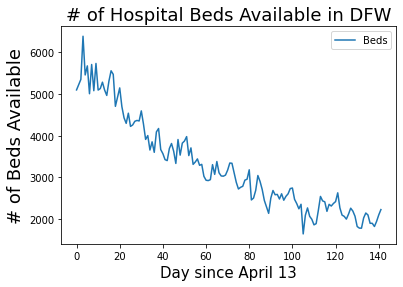

In [16]:
# Plot the data
import matplotlib.pyplot as plt

df.plot()
plt.title("# of Hospital Beds Available in DFW", fontsize=18)
plt.xlabel('Day since April 13',fontsize=15)
plt.ylabel('# of Beds Available',fontsize=18)
# plt.savefig('Hospital Beds Available.png', dpi=1200)
plt.show()

## Training the Model
Now that I have the data, I train the Prophet model on the data *(all dates before September)*.

In the second block, I create a `DataFrame` from the list of test dates I had set aside in the beginning. My model will predict the # of beds available on these test dates - *(September dates)* - based on the historical data it has been fed.

In [17]:
# prophet requires the column names to be "ds" and "y"
df.columns = ['ds', 'y']
# make the model
model = Prophet()
# train the model on the dataset (in this case dataframe df)
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
# Generate a list of future dates for the model to predict
future = DataFrame(testD)
future.columns = ['ds']
# Printing the September dates to forecast
future

,ds
0,2020-09-01
1,2020-09-02
2,2020-09-03
3,2020-09-04
4,2020-09-05
5,2020-09-06
6,2020-09-07
7,2020-09-08
8,2020-09-09
9,2020-09-10


## Testing the Model
In this step, I test the model and use it to predict the # of available hospital beds for the dates I generated above.

I then plot a graph showing the # of available beds since April 13th and a blue line that shows the # of beds my model predicted would be available on future dates.

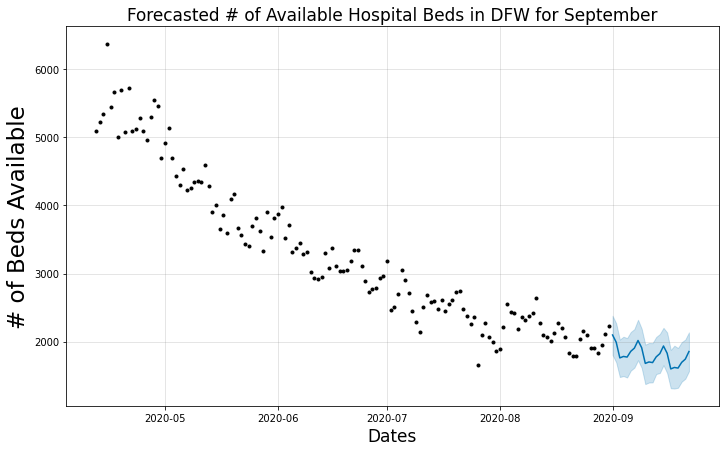

In [19]:
# forecast contains the predictions for the dates we provided
forecast = model.predict(future)

# This prints the date, expected # of beds available, and the lower and upper bounds of the forecasted interval
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# plot forecast
model.plot(forecast)
plt.title("Forecasted # of Available Hospital Beds in DFW for September", fontsize=17)
plt.xlabel('Dates',fontsize=17)
plt.ylabel('# of Beds Available',fontsize=23)
# plt.savefig('September Forecast.png', dpi=1200)
plt.show()

## Evaluating the Model
After having trained the model and having it predict the daily # of available beds from September 1st to 22nd, in this step I will evaluate the model's accuracy.

Among the useful information the model provides is the **expected # of available beds** and **an expected range of available beds** *(interval)*.

Below are some of the metrics I am examining

- Percent Error
- Mean Absolute Error (MAE)
- Percentage of Dates within predicted *interval*

### 1. Visualizing Forecasts vs Actual # of Available Beds

In [20]:
intervals = [] # Intervals of bed predictions
predicted = [] # Predicted # of available beds
differences = [] # Difference (actual - predicted)

# For each date that the model had to forecast, I get the predicted number of beds, and the confidence interval (or range of beds for that day)
for count, (pred, lower, upper) in enumerate(zip(forecast['yhat'], forecast['yhat_lower'], forecast['yhat_upper'])):
    intervals.append("{:.0f} - {:.0f}".format(lower, upper))
    differences.append(testX[count] - int(round(pred)))
    predicted.append(int(round(pred)))

# data frame of the summary between actual # and forecasted # of available beds
summary = pd.DataFrame({'Dates' : testD, 'Actual': testX, 'Predicted' : predicted, 
                       'Difference' : differences, 'Intervals' : intervals})
# Displaying the dataframe
print("       # of Beds Forecasted vs Actual")
summary

       # of Beds Forecasted vs Actual


,Dates,Actual,Predicted,Difference,Intervals
0,2020-09-01,2217,2096,121,1803 - 2379
1,2020-09-02,1930,1990,-60,1695 - 2267
2,2020-09-03,1782,1759,23,1478 - 2029
3,2020-09-04,1794,1781,13,1493 - 2071
4,2020-09-05,1896,1772,124,1471 - 2050
5,2020-09-06,2091,1856,235,1572 - 2140
6,2020-09-07,2195,1903,292,1616 - 2183
7,2020-09-08,2311,2015,296,1724 - 2320
8,2020-09-09,2300,1909,391,1613 - 2189
9,2020-09-10,1931,1678,253,1374 - 1954


### 2. Percent Error & Percent of accurate forecasted intervals
After getting the important data I need (forecasts and forecast range), I calculate the percent error of the forecast for each date in September and average them.

I also count the # of intervals that correctly captured the actual # of available beds on that day. ***Example:*** *For September 21st, the model forecasted that between 1504 to 2071 beds would be available. The actual number was 1782 which lies inside the interval, near the center, so the model's forecast contained the actual number.* 

In [32]:
error = []
absolute_error = 0 # Mean Absolute Error
contains = [] # True or False based on whether a forecasted interval contains the actual # of available beds
average = 0
for i in range (0, len(predicted)):
    # Calculate percent error for each date.  testX is a list of the actual # of beds
    average += (testX[i] - predicted[i])/testX[i] * 100
    error.append(round(((testX[i] - predicted[i])/testX[i] * 100)))
    absolute_error += abs(testX[i] - predicted[i])
    
    # Determining whether forecast interval contains actual # of beds
    lower_bound = forecast['yhat_lower'][i]
    upper_bound = forecast['yhat_upper'][i]
    contains.append((lower_bound <= testX[i] and testX[i] <= upper_bound))

# calculate average percent error
average = round(average/len(error),1)
# calculate mean absolute error
absolute_error = round(absolute_error / len(error))

# Count # of forecasted intervals that contained the actual # of available beds
numberCorrect = sum(interval for interval in contains)
percentCorrect = int((numberCorrect * 100)/len(contains))
print("---------------------------------")
print("AVERAGE PERCENT ERROR:", average, "%")
print("MEAN ABSOLUTE ERROR:", absolute_error, "beds\n")
print("On {0}% of the days ({1} out of 22 days), the model's forecast interval of the # of available beds contained the actual # of beds available on that day.".format(percentCorrect, numberCorrect))
print("---------------------------------")

results = pd.DataFrame({'Dates' : testD, 'Percent Error': [str(e) + "%" for e in error],
                        'Accurate Forecast Interval' : contains})
results

---------------------------------
AVERAGE PERCENT ERROR: 10.8 %
MEAN ABSOLUTE ERROR: 228 beds

On 81% of the days (18 out of 22 days), the model's forecast interval of the # of available beds contained the actual # of beds available on that day.
---------------------------------


,Dates,Percent Error,Accurate Forecast Interval
0,2020-09-01,5%,True
1,2020-09-02,-3%,True
2,2020-09-03,1%,True
3,2020-09-04,1%,True
4,2020-09-05,7%,True
5,2020-09-06,11%,True
6,2020-09-07,13%,True
7,2020-09-08,13%,False
8,2020-09-09,17%,False
9,2020-09-10,13%,True


## Results/Conclusion
- The model had an **average percent of error of about 10%.** Considering that the # of available beds in April was very different from how it is now, these are good results.
- Additionally, when predicting the # of beds available for the first 22 days in September, the model also provided an expected range of available beds. For **17 out of the 22 days (77%)**, this expected range accurately captured the correct # of available beds, meaning that the model can forecast the ballpark of number of beds available
- **The model's performance will improve as more time passes by and more data is available.**

# Part 2 - The Future
### Forecasting future dates - the next 31 days
In this part, I will train a model to forecast the daily # of available hospital beds in Dallas/Fort Worth for dates that have not yet arrived *(late September and October)*. 

This time, I will include data from September when training the model.

In [33]:
x = []

# Reading & storing the # of available beds in DFW
for bed_number in str(data["Dallas/Ft. Worth"]).split(" "):
    if(not bed_number[:1].isdigit()):
        continue
    
    x.append(int(getNumberFromString(bed_number)))
        
# Generate dates from April 12th to last date in the dataset
end_date = pd.to_datetime("2020-04-12") + pd.DateOffset(days=len(x) - 1)
dates = pd.date_range(start="2020-04-12",end=end_date)
dates = [str(i)[:10] for i in dates]

print("# of Dates:", len(dates), "\nFrom", dates[0], "to", dates[len(dates) - 1])

# of Dates: 164 
From 2020-04-12 to 2020-09-22


In [34]:
# Create a pandas DataFrame object from the list of dates and beds
df = pd.DataFrame({'Dates' : dates, 'Beds' : x})
# prophet requires the column names to be "ds" and "y"
df.columns = ['ds', 'y']
# make the model
model = Prophet()
# train the model on the dataset (in this case dataframe df)
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecasting future dates
The code below forecasts the # of available beds from **September 23rd to October 23rd**

In [35]:
# Generating a list of future dates for the model to forecast
future_dates = pd.date_range(start="2020-09-23",end="2020-10-23")
future = DataFrame(future_dates)
future.columns = ['ds']

In [36]:
# forecast contains the predictions for the dates we provided
forecast = model.predict(future)

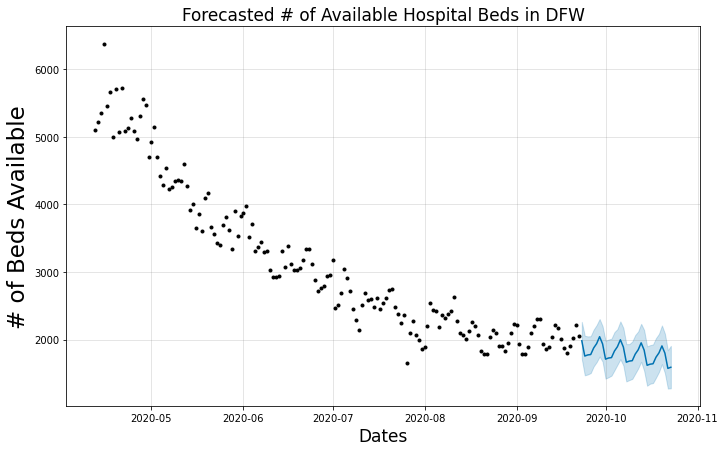

In [37]:
alternate = forecast[:]

model.plot(alternate)
plt.title("Forecasted # of Available Hospital Beds in DFW", fontsize=17)
plt.xlabel('Dates',fontsize=17)
plt.ylabel('# of Beds Available',fontsize=23)
# plt.savefig('Future Forecast.png', dpi=1200)
plt.show()

### Zoomed-in graph
The code below creates a graph that zooms in on the graph above. **It shows the last 31 days where the # of available beds was known next to the forecasted # of beds in Dallas from September 23rd to October 23rd.**

In [27]:
toplot = []
before = 31
for i in x[-before:]:
    toplot.append(i)
for i in alternate['yhat']:
    toplot.append(int(i))

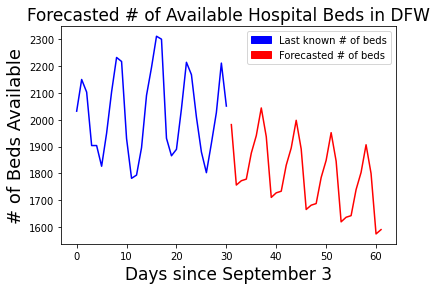

In [28]:
# total available beds
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
alternate

plt.title("Forecasted # of Available Hospital Beds in DFW", fontsize=17)
plt.xlabel('Days since September 3',fontsize=17)
plt.ylabel('# of Beds Available',fontsize=18)

# Generate the before and after lists for x values
x1 = [i for i in range(0,before)]
x2 = [i for i in range(before, len(alternate) + before)]

# Create the legend
blue_patch = mpatches.Patch(color='blue', label='Last known # of beds')
red_patch = mpatches.Patch(color='red', label='Forecasted # of beds')
plt.legend(handles=[blue_patch, red_patch])

plt.plot(x1, toplot[:before], color='blue')
plt.plot(x2, toplot[before:], color='red')

# plt.savefig('Future Forecast Zoomed.png', dpi=1200)

plt.show()

# End of Notebook   